In [41]:
import json
import os
import re
import fnmatch
from PIL import Image
from pathlib import Path
import numpy as np
import cv2
import csv
import copy
import xml.etree.ElementTree as ET
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from model.utils.net_utils import vis_detections
from pycocotools.coco import COCO

In [13]:
data_root = '/home/tony/datasets/OCID'
annotation_path = os.path.join(data_root, 'annotation.csv')
scene_list_path = os.path.join(data_root, 'scene_list.txt')

annotation_list = []
with open(annotation_path, newline='') as csvfile:
    rows = csv.DictReader(csvfile)
    for row in rows:
        annotation_list.append(row)
im_path_list = []
with open(scene_list_path, "r") as fp:
    for line in iter(fp):
        n, path = line.split()
        im_path_list.append((n, path))

## move images to folders

In [18]:
im_root = '/home/tony/datasets/OCID/OCID-dataset'
target_folder = '/home/tony/datasets/OCID/images'

for scene_id, _path in tqdm(im_path_list):
    scene_id = "%06d" % int(scene_id)
    file_name = scene_id + '.jpg'
    im_path = os.path.join(im_root, _path)
    im = cv2.imread(im_path)
    save_path = os.path.join(target_folder, file_name)
    cv2.imwrite(save_path, im)

## coco format

In [20]:
coco_json_path = '/home/tony/datasets/coco/annotations/instances_minival2014.json'
with open(coco_json_path, 'r') as f:
    data = json.load(f)
data.keys()

dict_keys(['info', 'licenses', 'images', 'type', 'annotations', 'categories'])

In [37]:
# create category
new_data_categories = []
for i, _cat in enumerate(cats):   
    cat_id  = i + 1
    dic = {}
    dic['supercategory'] = 'None'
    dic['id'] = cat_id
    dic['name'] = _cat
    new_data_categories.append(dic)
    
cls_name_to_id = {}
for cat in new_data_categories:
    cls_name_to_id[cat['name']] = cat['id']

In [30]:
# create images
new_data_images = []
for i in tqdm(range(2300)):
    _id = "%06d" % i
    file_name = _id + '.jpg'
    dic = {}
    dic['license'] = 1
    dic['file_name'] = file_name
    dic['coco_url'] = 'http://farm3.staticflickr.com/2253/1755223462_fabbeb8dc3_z.jpg'
    
    im_path = os.path.join(target_folder, file_name)
    im = cv2.imread(im_path)
    dic['height'] = im.shape[0]
    dic['width'] = im.shape[1]

    dic['date_captured'] = '2013-11-15 13:55:22'
    dic['id'] = i
    new_data_images.append(dic)

In [39]:
# create annotations
new_data_annotations = []
ann_cnt = 0
for i, ann in enumerate(annotation_list):
    scene_id = int(ann['scene_idx'])
    bbox = ann['bbox'][1:-1].replace(",", "").split()
    bbox = [int(s) for s in bbox]
    cls_name = ann['new_class']
    cls_id = cls_name_to_id[cls_name]
    
    dic = {}
    dic['segmentation'] = [[184.05]]
    dic['area'] = 1.28
    dic['iscrowd'] = 0
    dic['image_id'] = scene_id
    dic['bbox'] = [bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]]
    dic['category_id'] = cls_id
    ann_cnt += 1
    dic['id'] = ann_cnt 
    new_data_annotations.append(dic)

In [42]:
coco_json_path = '/home/tony/datasets/coco/annotations/instances_train2014.json'
with open(coco_json_path, 'r') as f:
    data = json.load(f)
new_data_info = data['info']
new_data_licenses = data['licenses']

new_dict = {}
new_dict['info'] = new_data_info
new_dict['images'] = new_data_images
new_dict['licenses'] = new_data_licenses
new_dict['annotations'] = new_data_annotations
new_dict['categories'] = new_data_categories

dump_path = '/home/tony/datasets/OCID/annotations/instances_train2020.json'
with open(dump_path, 'w') as f:
    json.dump(new_dict, f)

In [43]:
_COCO = COCO(dump_path)

print(len(_COCO.imgs))
print(len(_COCO.anns))
print(len(_COCO.cats))

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
2300
17847
23


In [48]:
n_each_class = np.zeros(24)
for ann in new_dict['annotations']:
    n_each_class[ann['category_id']] += 1
n_each_class

array([   0., 5011.,  235., 1517.,  232.,  978., 2519.,  814.,  576.,
       1008.,  310.,  234.,  411.,  396.,  684., 1206.,  404.,  318.,
        204.,  502.,  110.,   40.,   80.,   58.])

In [45]:
new_dict['annotations'][0]

{'segmentation': [[184.05]],
 'area': 1.28,
 'iscrowd': 0,
 'image_id': 0,
 'bbox': [212, 172, 205, 111],
 'category_id': 1,
 'id': 1}

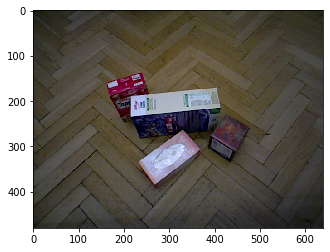

In [69]:
im_root = '/home/tony/datasets/OCID/OCID-dataset'

im_path = os.path.join(im_root, im_path_list[3])
im = Image.open(im_path)
plt.imshow(im)

In [68]:
dets = []
for ann in annotation_list:
    if ann['scene_idx'] == str(3):
        bbox = ann['bbox'][1:-1].replace(",", "").split()
        bbox = [int(s) for s in bbox]
        dets.append(bbox)
dets = np.asarray(dets)
dets

array([[212, 172, 417, 283],
       [387, 228, 480, 335],
       [232, 264, 369, 394],
       [160, 139, 254, 246]])

In [ ]:
im2show = vis_detections(im2show, ' ', cls_dets.cpu().numpy(), 0.5)

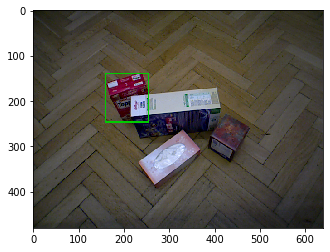

In [75]:
bbox = dets[3]
im2show = np.array(im.copy())
im2show = cv2.rectangle(im2show, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 204, 0), 2)
plt.imshow(im2show)

In [63]:
bbox[0:2]

array([212, 172])

In [57]:
im2show = im.copy()
im2show = vis_detections(im2show, ' ', dets, 0.5)

TypeError: an integer is required (got type tuple)

In [12]:
file_path_list = []
fp = open(scene_list_path, "r")
for line in iter(fp):
    n, path = line.split()
    file_path_list.append(path)
fp.close()
file_path_list[:3]

['ARID10/floor/top/box/seq03/rgb/result_2018-08-27-15-54-11.png',
 'ARID10/floor/top/box/seq03/rgb/result_2018-08-27-15-54-31.png',
 'ARID10/floor/top/box/seq03/rgb/result_2018-08-27-15-54-52.png']